#YELP REVIEW RATING PREDICTION

**<h1>Task 1: Implement 4 prompting approaches**


# STEP 1: INSTALL REQUIRED PACKAGES

In [1]:
# Install dependencies
!pip install -q groq pandas scikit-learn matplotlib seaborn threadpoolctl --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 51.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import json
import time
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

from groq import Groq

# STEP 2: SETUP OPENROUTER API

In [ ]:
client = Groq(api_key="")

MODEL = "qwen/qwen3-32b"


In [25]:
def call_groq(prompt: str, max_retries=10):
    for i in range(max_retries):
        try:
            chat_completion = client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model=MODEL,
                temperature=0.0,
                max_tokens=512,
                top_p=1
            )
            return chat_completion.choices[0].message.content.strip()
        except Exception as e:
            if "rate limit" in str(e).lower() or "429" in str(e):
                wait = 2 ** i
                print(f"Rate limit hit → sleeping {wait}s")
                time.sleep(wait)
            else:
                print(f"Error: {str(e)[:80]}")
                time.sleep(1)
    return None

# ROBUST JSON EXTRACTOR

In [5]:
def extract_json(text: str):
    if not text:
        return None
    text = text.strip()
    # Direct JSON
    try: return json.loads(text)
    except: pass
    # Find first { ... last }
    start = text.find('{')
    if start == -1: return None
    brace_count = 0
    for end in range(start, len(text)):
        if text[end] == '{': brace_count += 1
        elif text[end] == '}': brace_count -= 1
        if brace_count == 0: break
    try: return json.loads(text[start:end+1])
    except: pass
    # Regex fallback
    m = re.search(r'"predicted_stars"\s*:\s*([1-5])', text, re.I)
    if m:
        return {"predicted_stars": int(m.group(1)), "explanation": "regex fallback"}
    return None

# STEP 3: LOAD AND PREPARE DATASET

In [14]:
print("Loading Yelp dataset...")
df = pd.read_csv('/content/yelp.csv')
df

Loading Yelp dataset...


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,VY_tvNUCCXGXQeSvJl757Q,2012-07-28,Ubyfp2RSDYW0g7Mbr8N3iA,3,First visit...Had lunch here today - used my G...,review,_eqQoPtQ3e3UxLE4faT6ow,1,2,0
9996,EKzMHI1tip8rC1-ZAy64yg,2012-01-18,2XyIOQKbVFb6uXQdJ0RzlQ,4,Should be called house of deliciousness!\n\nI ...,review,ROru4uk5SaYc3rg8IU7SQw,0,0,0
9997,53YGfwmbW73JhFiemNeyzQ,2010-11-16,jyznYkIbpqVmlsZxSDSypA,4,I recently visited Olive and Ivy for business ...,review,gGbN1aKQHMgfQZkqlsuwzg,0,0,0
9998,9SKdOoDHcFoxK5ZtsgHJoA,2012-12-02,5UKq9WQE1qQbJ0DJbc-B6Q,2,My nephew just moved to Scottsdale recently so...,review,0lyVoNazXa20WzUyZPLaQQ,0,0,0


In [15]:
print(f"Total reviews in dataset: {len(df)}")
print(f"\nDataset columns: {df.columns.tolist()}")
print(f"\nStar distribution:\n{df['stars'].value_counts().sort_index()}")

Total reviews in dataset: 10000

Dataset columns: ['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id', 'cool', 'useful', 'funny']

Star distribution:
stars
1     749
2     927
3    1461
4    3526
5    3337
Name: count, dtype: int64


In [16]:
# Sample 200 reviews for evaluation (balanced across star ratings)
# This ensures we test on all rating levels
sample_size = 200
sample_per_star = sample_size // 5

sampled_dfs = []
for star in range(1, 6):
    star_df = df[df['stars'] == star].sample(n=min(sample_per_star, len(df[df['stars'] == star])), random_state=42)
    sampled_dfs.append(star_df)

sample_df = pd.concat(sampled_dfs, ignore_index=True)
sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print(f"\nSampled {len(sample_df)} reviews for evaluation")
print(f"Sampled star distribution:\n{sample_df['stars'].value_counts().sort_index()}")



Sampled 200 reviews for evaluation
Sampled star distribution:
stars
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64


# STEP 4: DEFINE ALL 4 PROMPTING APPROACHES

In [17]:
def approach_1_zero_shot_improved(review_text: str) -> str:
    """
    Approach 1: Zero-Shot with Clear Instructions
    Key improvements:
    - Explicit JSON format requirements
    - Clear rating criteria
    - Examples of what each star means
    """
    prompt = f"""You are an expert Yelp review analyst. Analyze this review and predict the star rating (1-5).

Rating Guidelines:
- 5 stars: Exceptional, enthusiastic, highly recommends
- 4 stars: Good with minor issues, would return
- 3 stars: Average, neutral, mixed feelings
- 2 stars: Below average, disappointed, some problems
- 1 star: Terrible, angry, multiple major issues

Review: "{review_text}"

IMPORTANT: Respond with ONLY valid JSON, no other text:
{{"predicted_stars": <number 1-5>, "explanation": "<one sentence>"}}"""

    return call_groq(prompt)

In [18]:
def approach_2_few_shot_improved(review_text: str) -> str:
    """
    Approach 2: Few-Shot with Diverse Examples
    Key improvements:
    - More diverse and realistic examples
    - Show reasoning patterns
    - Cover edge cases
    """
    prompt = f"""You are an expert at rating Yelp reviews. Study these examples:

Example 1: "Absolutely terrible! Cold food, rude staff, overpriced. Never again!" → 1 star
Reasoning: Multiple severe complaints, strong negative emotion, definite non-return

Example 2: "Food was mediocre, service slow. Not worth the price honestly." → 2 stars
Reasoning: Below expectations on multiple aspects, value concern

Example 3: "Pretty standard experience. Food was okay, nothing special. Service fine." → 3 stars
Reasoning: Neutral tone, average on all aspects, no strong feelings

Example 4: "Really enjoyed it! Good food and nice atmosphere. One small issue with timing but overall great!" → 4 stars
Reasoning: Positive experience with minor flaw mentioned, would return

Example 5: "WOW! Best meal ever! Amazing service, perfect in every way! Can't wait to come back!!" → 5 stars
Reasoning: Extreme enthusiasm, superlatives, exclamation marks, highest recommendation

Now rate this review following the same logic:

Review: "{review_text}"

Respond with ONLY this JSON format:
{{"predicted_stars": <number 1-5>, "explanation": "<one sentence>"}}"""

    return call_groq(prompt)

In [19]:
def approach_3_chain_of_thought_improved(review_text: str) -> str:
    """
    Approach 3: Enhanced Chain-of-Thought
    Key improvements:
    - More systematic analysis steps
    - Quantify sentiment strength
    - Consider context and nuance
    """
    prompt = f"""Analyze this Yelp review systematically to determine the star rating.

Review: "{review_text}"

Step-by-step analysis:

1. SENTIMENT WORDS: List positive words (e.g., great, loved) and negative words (e.g., terrible, disappointed)

2. INTENSITY: Rate emotional intensity as:
   - Mild: calm, factual language
   - Moderate: some emotion, clear opinion
   - Strong: exclamation marks, superlatives, extreme words

3. SPECIFIC ASPECTS: What's mentioned about:
   - Quality (food/product/service quality)
   - Service (staff behavior, speed)
   - Value (price vs quality)
   - Overall experience

4. WOULD RETURN?: Based on tone, would reviewer:
   - Definitely not (1 star)
   - Probably not (2 stars)
   - Maybe/Unsure (3 stars)
   - Probably yes (4 stars)
   - Definitely yes (5 stars)

5. FINAL RATING: Combine all factors above

Respond with ONLY this JSON:
{{"sentiment_analysis": "<positive/negative words found>", "intensity": "<mild/moderate/strong>", "aspects": "<key points>", "would_return": "<yes/no/maybe>", "predicted_stars": <number 1-5>, "explanation": "<one sentence>"}}"""

    return call_groq(prompt)

In [20]:
def approach_4_aspect_based_improved(review_text: str) -> str:
    """
    Approach 4: Structured Aspect-Based with Weighted Scoring
    Key improvements:
    - Clear scoring rubric
    - Weighted importance
    - Handle missing aspects gracefully
    """
    prompt = f"""Rate this Yelp review by analyzing specific aspects. Score each mentioned aspect 1-5, or 0 if not mentioned.

Review: "{review_text}"

Scoring rubric for each aspect (1=terrible, 2=poor, 3=okay, 4=good, 5=excellent, 0=not mentioned):

1. QUALITY: Product/food/service quality, freshness, taste, presentation
2. SERVICE: Staff friendliness, attentiveness, speed, professionalism
3. ATMOSPHERE: Ambiance, cleanliness, comfort, aesthetic
4. VALUE: Price fairness, portion size, worth the cost
5. OVERALL: Would they recommend? General satisfaction

Calculation method:
- Get average of all NON-ZERO scores
- Round to nearest integer (1-5)
- If mostly positive aspects but one major complaint, reduce by 1
- If mostly negative but one positive mention, it's still low (1-2)

Respond with ONLY this JSON:
{{"aspects": {{"quality": <0-5>, "service": <0-5>, "atmosphere": <0-5>, "value": <0-5>, "overall": <0-5>}}, "predicted_stars": <number 1-5>, "explanation": "<one sentence>"}}"""

    return call_groq(prompt)

# STEP 6: RUN ALL APPROACHES ON SAMPLE DATA

In [21]:
print("\n📁 Loading Yelp dataset...")
df = pd.read_csv('yelp.csv')  # Update path if needed

print(f"Total reviews: {len(df)}")
print(f"\nStar distribution:\n{df['stars'].value_counts().sort_index()}")

# Sample balanced dataset - 20 reviews per star rating = 100 total
# (Increase this for more comprehensive evaluation)
sample_size_per_star = 40

sampled_dfs = []
for star in range(1, 6):
    star_df = df[df['stars'] == star].sample(
        n=min(sample_size_per_star, len(df[df['stars'] == star])),
        random_state=42
    )
    sampled_dfs.append(star_df)

sample_df = pd.concat(sampled_dfs, ignore_index=True)
sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✅ Sampled {len(sample_df)} reviews for evaluation")
print(f"Balanced distribution:\n{sample_df['stars'].value_counts().sort_index()}")


📁 Loading Yelp dataset...
Total reviews: 10000

Star distribution:
stars
1     749
2     927
3    1461
4    3526
5    3337
Name: count, dtype: int64

✅ Sampled 200 reviews for evaluation
Balanced distribution:
stars
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64


In [26]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import time

print("\nSTARTING GROQ-SAFE EVALUATION")
print("200 reviews × 4 approaches = 800 API calls")
print("Fully compliant with free-tier limits\n")

approaches = {
    'Approach 1: Zero-Shot': approach_1_zero_shot_improved,
    'Approach 2: Few-Shot': approach_2_few_shot_improved,
    'Approach 3: Chain-of-Thought': approach_3_chain_of_thought_improved,
    'Approach 4: Aspect-Based': approach_4_aspect_based_improved
}

results = {name: [] for name in approaches}
total_calls = len(sample_df) * len(approaches)  # 800


MAX_WORKERS = 20        # 8 workers = ~28–29 requests/min → under 30
SLEEP_BETWEEN_CALLS = 0.12   # 120ms → perfectly balances speed & safety

print(f"Settings:")
print(f"   Workers         : {MAX_WORKERS}")
print(f"   Delay per call  : {SLEEP_BETWEEN_CALLS}s")
print(f"   Est. time       : ~5.5 – 6.5 minutes")
print(f"   Max req/min     : ~29 < 30 (safe)")
print(f"   Max tokens/min  : < 6K (very safe)\n")


def process_one(review_idx, text, actual_stars, approach_name, func):
    try:
        start = time.time()
        raw = func(text)
        parsed = extract_json(raw)
        pred = None
        expl = "No explanation"
        if parsed and "predicted_stars" in parsed:
            pred = int(parsed["predicted_stars"])
            expl = parsed.get("explanation", "")
        success = pred is not None and 1 <= pred <= 5
        return {
            "idx": review_idx,
            "approach": approach_name,
            "actual": actual_stars,
            "predicted": pred,
            "explanation": expl,
            "success": success,
            "response_time": round(time.time() - start, 3)
        }
    except Exception as e:
        return {
            "idx": review_idx,
            "approach": approach_name,
            "actual": actual_stars,
            "predicted": None,
            "explanation": f"ERROR: {e}",
            "success": False
        }


start_time = time.time()
celebrated = set()

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = []

    for idx, row in sample_df.iterrows():
        for name, func in approaches.items():
            time.sleep(SLEEP_BETWEEN_CALLS)  # Critical for staying under 30/min
            futures.append(
                executor.submit(process_one, idx, row['text'], row['stars'], name, func)
            )

    print("Running 800 calls... (progress + celebrations)\n")

    for i, future in enumerate(tqdm(as_completed(futures), total=total_calls, desc="Groq Calls", unit="call")):
        result = future.result()
        results[result["approach"]].append(result)

        # Milestone celebrations
        progress = (i + 1) / total_calls
        if any(progress >= m and m not in celebrated for m in [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 1.0]):
            for m in [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 1.0]:
                if progress >= m > max(celebrated, default=0):
                    print(f"\n{int(m*100)}% COMPLETE! ALMOST THERE!\n")
                    celebrated.add(m)
                    break


elapsed = (time.time() - start_time) / 60
successful = sum(1 for r in results.values() for x in r if x["success"])

print("\n" + "GROQ EVALUATION 100% COMPLETE!")
print("="*90)
print(f"Time taken           : {elapsed:.1f} minutes")
print(f"Total calls          : {total_calls}")
print(f"Successful calls     : {successful}/{total_calls} ({successful/total_calls:.1%})")
print(f"Requests per minute  : {total_calls/elapsed:.1f} (well under 30/min)")
print("\nAll results saved → ready for metrics & plots!")
print("You stayed safely within free-tier limits!")


STARTING GROQ-SAFE EVALUATION
200 reviews × 4 approaches = 800 API calls
Fully compliant with free-tier limits

Settings:
   Workers         : 20
   Delay per call  : 0.12s
   Est. time       : ~5.5 – 6.5 minutes
   Max req/min     : ~29 < 30 (safe)
   Max tokens/min  : < 6K (very safe)

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit

Groq Calls:   0%|          | 0/800 [00:00<?, ?call/s]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 16s


Groq Calls:   2%|▏         | 12/800 [00:08<08:53,  1.48call/s]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s


Groq Calls:   2%|▏         | 13/800 [00:13<15:32,  1.18s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 64s


Groq Calls:   2%|▏         | 14/800 [00:17<20:04,  1.53s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s


Groq Calls:   2%|▏         | 15/800 [00:22<27:32,  2.10s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:   2%|▏         | 16/800 [00:27<34:51,  2.67s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s


Groq Calls:   2%|▏         | 17/800 [00:33<43:22,  3.32s/call]

Rate limit hit → sleeping 64s


Groq Calls:   2%|▏         | 18/800 [00:34<35:43,  2.74s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:   2%|▏         | 19/800 [00:39<42:06,  3.23s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:   2%|▎         | 20/800 [00:44<49:52,  3.84s/call]

Rate limit hit → sleeping 2s


Groq Calls:   3%|▎         | 22/800 [00:47<37:56,  2.93s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:   3%|▎         | 23/800 [00:52<43:37,  3.37s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:   3%|▎         | 24/800 [00:58<50:36,  3.91s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 128s


Groq Calls:   3%|▎         | 25/800 [01:03<53:58,  4.18s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:   3%|▎         | 27/800 [01:10<50:58,  3.96s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 128s


Groq Calls:   4%|▎         | 28/800 [01:15<56:13,  4.37s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s


Groq Calls:   4%|▎         | 29/800 [01:21<58:49,  4.58s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s


Groq Calls:   4%|▍         | 30/800 [01:23<52:10,  4.07s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 128s


Groq Calls:   4%|▍         | 31/800 [01:28<55:13,  4.31s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 64s


Groq Calls:   4%|▍         | 32/800 [01:33<56:05,  4.38s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s


Groq Calls:   4%|▍         | 33/800 [01:39<1:01:31,  4.81s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s


Groq Calls:   4%|▍         | 34/800 [01:42<55:22,  4.34s/call]  

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 2s


Groq Calls:   4%|▍         | 35/800 [01:47<58:33,  4.59s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s


Groq Calls:   5%|▍         | 37/800 [01:55<54:10,  4.26s/call]  

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:   5%|▍         | 38/800 [01:58<49:25,  3.89s/call]

Rate limit hit → sleeping 1s


Groq Calls:   5%|▍         | 39/800 [02:03<52:28,  4.14s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:   5%|▌         | 40/800 [02:09<59:45,  4.72s/call]


5% COMPLETE! ALMOST THERE!

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 128s


Groq Calls:   5%|▌         | 41/800 [02:15<1:04:18,  5.08s/call]

Rate limit hit → sleeping 2s


Groq Calls:   5%|▌         | 42/800 [02:18<55:52,  4.42s/call]  

Rate limit hit → sleeping 16s


Groq Calls:   5%|▌         | 43/800 [02:23<56:06,  4.45s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 1s


Groq Calls:   6%|▌         | 44/800 [02:28<1:01:08,  4.85s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 64s


Groq Calls:   6%|▌         | 45/800 [02:33<59:48,  4.75s/call]  

Rate limit hit → sleeping 1s


Groq Calls:   6%|▌         | 46/800 [02:36<52:52,  4.21s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 128s


Groq Calls:   6%|▌         | 47/800 [02:41<55:44,  4.44s/call]

Rate limit hit → sleeping 1s


Groq Calls:   6%|▌         | 48/800 [02:47<1:02:20,  4.97s/call]

Rate limit hit → sleeping 2s


Groq Calls:   6%|▌         | 49/800 [02:53<1:06:19,  5.30s/call]

Rate limit hit → sleeping 4s


Groq Calls:   6%|▋         | 50/800 [02:59<1:07:12,  5.38s/call]

Rate limit hit → sleeping 128s


Groq Calls:   6%|▋         | 52/800 [03:11<1:12:29,  5.82s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 1s


Groq Calls:   7%|▋         | 54/800 [03:19<59:22,  4.78s/call]  

Rate limit hit → sleeping 1s


Groq Calls:   7%|▋         | 55/800 [03:23<58:31,  4.71s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:   7%|▋         | 56/800 [03:29<1:02:09,  5.01s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 256s


Groq Calls:   7%|▋         | 57/800 [03:34<1:03:08,  5.10s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s


Groq Calls:   7%|▋         | 58/800 [03:40<1:04:14,  5.19s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit

Groq Calls:   7%|▋         | 59/800 [04:37<4:16:55, 20.80s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s


Groq Calls:   8%|▊         | 60/800 [05:56<7:52:53, 38.34s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 2s


Groq Calls:   8%|▊         | 63/800 [06:37<4:15:20, 20.79s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 64s


Groq Calls:   8%|▊         | 64/800 [06:43<3:22:52, 16.54s/call]

Rate limit hit → sleeping 1s


Groq Calls:   8%|▊         | 66/800 [06:53<2:08:26, 10.50s/call]

Rate limit hit → sleeping 1s


Groq Calls:   8%|▊         | 67/800 [06:59<1:51:09,  9.10s/call]

Rate limit hit → sleeping 128s


Groq Calls:   8%|▊         | 68/800 [07:05<1:36:51,  7.94s/call]

Rate limit hit → sleeping 2s


Groq Calls:   9%|▊         | 69/800 [07:12<1:36:05,  7.89s/call]

Rate limit hit → sleeping 4s


Groq Calls:   9%|▉         | 72/800 [07:26<1:10:00,  5.77s/call]

Rate limit hit → sleeping 8s


Groq Calls:   9%|▉         | 74/800 [07:35<1:01:45,  5.10s/call]

Rate limit hit → sleeping 512s


Groq Calls:  10%|▉         | 76/800 [07:44<56:24,  4.67s/call]

Rate limit hit → sleeping 16s


Groq Calls:  10%|▉         | 77/800 [07:49<55:44,  4.63s/call]

Rate limit hit → sleeping 512s


Groq Calls:  10%|▉         | 78/800 [07:52<52:56,  4.40s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  10%|▉         | 79/800 [07:57<55:24,  4.61s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  10%|█         | 80/800 [08:03<59:46,  4.98s/call]


10% COMPLETE! ALMOST THERE!

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 2s


Groq Calls:  10%|█         | 81/800 [08:09<1:02:07,  5.18s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 512s


Groq Calls:  10%|█         | 82/800 [08:13<58:31,  4.89s/call]  

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 512s


Groq Calls:  10%|█         | 83/800 [08:18<59:34,  4.99s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  10%|█         | 84/800 [08:24<1:00:13,  5.05s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 512s


Groq Calls:  11%|█         | 86/800 [08:29<43:37,  3.67s/call]  

Rate limit hit → sleeping 512s


Groq Calls:  11%|█         | 87/800 [08:34<46:07,  3.88s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 1s


Groq Calls:  11%|█         | 88/800 [08:39<53:14,  4.49s/call]

Rate limit hit → sleeping 1s


Groq Calls:  11%|█         | 89/800 [08:46<1:00:38,  5.12s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 64s


Groq Calls:  11%|█▏        | 91/800 [08:57<1:05:07,  5.51s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 512s


Groq Calls:  12%|█▏        | 92/800 [09:04<1:10:26,  5.97s/call]

Rate limit hit → sleeping 1s


Groq Calls:  12%|█▏        | 93/800 [09:11<1:12:47,  6.18s/call]

Rate limit hit → sleeping 1s


Groq Calls:  12%|█▏        | 94/800 [09:14<1:01:27,  5.22s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  12%|█▏        | 95/800 [09:20<1:04:26,  5.48s/call]

Rate limit hit → sleeping 2s


Groq Calls:  12%|█▏        | 96/800 [09:26<1:07:01,  5.71s/call]

Rate limit hit → sleeping 4s


Groq Calls:  13%|█▎        | 101/800 [09:56<1:08:34,  5.89s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 128s


Groq Calls:  13%|█▎        | 102/800 [10:02<1:12:14,  6.21s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 256s


Groq Calls:  13%|█▎        | 103/800 [10:09<1:12:16,  6.22s/call]

Rate limit hit → sleeping 1s


Groq Calls:  13%|█▎        | 104/800 [10:17<1:20:56,  6.98s/call]

Rate limit hit → sleeping 1s


Groq Calls:  13%|█▎        | 106/800 [10:29<1:12:10,  6.24s/call]

Rate limit hit → sleeping 2s


Groq Calls:  14%|█▎        | 108/800 [10:41<1:10:14,  6.09s/call]

Rate limit hit → sleeping 4s


Groq Calls:  14%|█▍        | 110/800 [10:52<1:05:42,  5.71s/call]

Rate limit hit → sleeping 8s


Groq Calls:  14%|█▍        | 114/800 [11:14<1:01:34,  5.39s/call]

Rate limit hit → sleeping 16s


Groq Calls:  15%|█▍        | 118/800 [11:37<1:03:41,  5.60s/call]

Rate limit hit → sleeping 32s


Groq Calls:  15%|█▌        | 123/800 [12:11<1:09:36,  6.17s/call]

Rate limit hit → sleeping 256s


Groq Calls:  16%|█▌        | 124/800 [12:17<1:09:51,  6.20s/call]

Rate limit hit → sleeping 64s


Groq Calls:  16%|█▋        | 130/800 [12:55<1:09:26,  6.22s/call]

Rate limit hit → sleeping 512s


Groq Calls:  17%|█▋        | 137/800 [13:36<1:02:14,  5.63s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 128s


Groq Calls:  18%|█▊        | 147/800 [14:31<1:00:23,  5.55s/call]

Rate limit hit → sleeping 512s


Groq Calls:  20%|█▉        | 159/800 [15:54<1:04:05,  6.00s/call]

Rate limit hit → sleeping 256s


Groq Calls:  21%|██        | 169/800 [16:31<30:35,  2.91s/call]

Rate limit hit → sleeping 1s


Groq Calls:  21%|██▏       | 171/800 [16:32<19:07,  1.82s/call]

Rate limit hit → sleeping 1s


Groq Calls:  22%|██▏       | 174/800 [16:40<21:45,  2.09s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  22%|██▏       | 177/800 [16:46<18:44,  1.80s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  22%|██▏       | 178/800 [16:51<29:46,  2.87s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  22%|██▏       | 179/800 [16:54<29:31,  2.85s/call]

Rate limit hit → sleeping 1s


Groq Calls:  23%|██▎       | 184/800 [16:57<09:28,  1.08call/s]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  23%|██▎       | 186/800 [17:02<15:31,  1.52s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  24%|██▎       | 188/800 [17:08<22:49,  2.24s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  24%|██▍       | 190/800 [17:15<24:35,  2.42s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  24%|██▍       | 191/800 [17:21<36:14,  3.57s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  24%|██▍       | 192/800 [17:28<45:03,  4.45s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  24%|██▍       | 193/800 [17:36<55:55,  5.53s/call]

Rate limit hit → sleeping 1s


Groq Calls:  24%|██▍       | 194/800 [17:40<49:35,  4.91s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s


Groq Calls:  24%|██▍       | 195/800 [17:45<51:07,  5.07s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  24%|██▍       | 196/800 [17:51<52:11,  5.18s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  25%|██▍       | 197/800 [18:00<1:03:34,  6.33s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s


Groq Calls:  25%|██▍       | 198/800 [18:07<1:06:13,  6.60s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  25%|██▍       | 199/800 [18:15<1:09:50,  6.97s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  25%|██▌       | 200/800 [18:23<1:13:55,  7.39s/call]


25% COMPLETE! ALMOST THERE!

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  25%|██▌       | 201/800 [18:31<1:16:04,  7.62s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  25%|██▌       | 202/800 [18:39<1:16:12,  7.65s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 1s


Groq Calls:  25%|██▌       | 203/800 [18:47<1:16:41,  7.71s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  26%|██▌       | 204/800 [18:55<1:19:20,  7.99s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  26%|██▌       | 205/800 [19:05<1:24:13,  8.49s/call]

Rate limit hit → sleeping 1s


Groq Calls:  26%|██▌       | 206/800 [19:09<1:11:13,  7.20s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  26%|██▌       | 207/800 [19:15<1:06:55,  6.77s/call]

Rate limit hit → sleeping 16s


Groq Calls:  26%|██▌       | 208/800 [19:22<1:06:23,  6.73s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 8s


Groq Calls:  26%|██▌       | 209/800 [19:27<1:02:21,  6.33s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s


Groq Calls:  26%|██▋       | 210/800 [19:30<53:09,  5.41s/call]  

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  26%|██▋       | 211/800 [19:35<52:08,  5.31s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  26%|██▋       | 212/800 [19:40<50:38,  5.17s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  27%|██▋       | 213/800 [19:52<1:08:27,  7.00s/call]

Rate limit hit → sleeping 16s


Groq Calls:  27%|██▋       | 214/800 [19:54<56:12,  5.76s/call]  

Rate limit hit → sleeping 32s


Groq Calls:  27%|██▋       | 215/800 [20:00<54:30,  5.59s/call]

Rate limit hit → sleeping 8s


Groq Calls:  27%|██▋       | 217/800 [20:07<42:49,  4.41s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  27%|██▋       | 218/800 [20:12<44:15,  4.56s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  27%|██▋       | 219/800 [20:16<45:03,  4.65s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  28%|██▊       | 220/800 [20:22<46:25,  4.80s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  28%|██▊       | 222/800 [20:30<41:43,  4.33s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  28%|██▊       | 224/800 [20:41<49:02,  5.11s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 128s


Groq Calls:  28%|██▊       | 225/800 [20:48<53:19,  5.56s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s


Groq Calls:  28%|██▊       | 226/800 [20:55<58:18,  6.09s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  28%|██▊       | 227/800 [21:03<1:01:51,  6.48s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 64s


Groq Calls:  28%|██▊       | 228/800 [21:10<1:02:58,  6.61s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 64s


Groq Calls:  29%|██▉       | 230/800 [21:22<1:00:55,  6.41s/call]

Rate limit hit → sleeping 2s


Groq Calls:  29%|██▉       | 231/800 [21:28<59:27,  6.27s/call]  

Rate limit hit → sleeping 64s


Groq Calls:  29%|██▉       | 233/800 [21:35<45:45,  4.84s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  29%|██▉       | 234/800 [21:43<54:14,  5.75s/call]

Rate limit hit → sleeping 64s


Groq Calls:  29%|██▉       | 235/800 [21:51<59:46,  6.35s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 1s


Groq Calls:  30%|██▉       | 236/800 [22:01<1:10:38,  7.51s/call]

Rate limit hit → sleeping 1s


Groq Calls:  30%|██▉       | 239/800 [22:12<43:36,  4.66s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 1s


Groq Calls:  30%|███       | 241/800 [22:26<53:43,  5.77s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s


Groq Calls:  30%|███       | 242/800 [22:30<50:05,  5.39s/call]

Rate limit hit → sleeping 4s


Groq Calls:  30%|███       | 243/800 [22:35<49:26,  5.33s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 128s


Groq Calls:  30%|███       | 244/800 [22:41<49:15,  5.32s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s


Groq Calls:  31%|███       | 246/800 [22:51<47:36,  5.16s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 128s


Groq Calls:  31%|███       | 247/800 [22:58<51:46,  5.62s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 8s


Groq Calls:  31%|███       | 249/800 [23:04<38:10,  4.16s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 256s


Groq Calls:  31%|███▏      | 250/800 [23:09<38:40,  4.22s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 128s


Groq Calls:  31%|███▏      | 251/800 [23:14<43:03,  4.71s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  32%|███▏      | 252/800 [23:20<46:54,  5.14s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  32%|███▏      | 253/800 [23:28<53:29,  5.87s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  32%|███▏      | 254/800 [23:33<50:14,  5.52s/call]

Rate limit hit → sleeping 8s


Groq Calls:  32%|███▏      | 256/800 [23:46<50:03,  5.52s/call]  

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  32%|███▏      | 259/800 [24:04<51:13,  5.68s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  32%|███▎      | 260/800 [24:11<54:31,  6.06s/call]

Rate limit hit → sleeping 1s


Groq Calls:  33%|███▎      | 261/800 [24:17<55:49,  6.21s/call]

Rate limit hit → sleeping 16s


Groq Calls:  33%|███▎      | 262/800 [24:21<50:20,  5.61s/call]

Rate limit hit → sleeping 1s


Groq Calls:  33%|███▎      | 263/800 [24:28<52:41,  5.89s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  33%|███▎      | 264/800 [24:34<53:46,  6.02s/call]

Rate limit hit → sleeping 4s


Groq Calls:  33%|███▎      | 266/800 [24:46<51:25,  5.78s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 8s


Groq Calls:  33%|███▎      | 267/800 [24:53<55:24,  6.24s/call]

Rate limit hit → sleeping 32s


Groq Calls:  34%|███▎      | 268/800 [25:01<1:00:26,  6.82s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 16s


Groq Calls:  34%|███▎      | 269/800 [25:09<1:02:53,  7.11s/call]

Rate limit hit → sleeping 256s


Groq Calls:  34%|███▍      | 270/800 [25:14<56:27,  6.39s/call]  

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s


Groq Calls:  34%|███▍      | 272/800 [25:18<35:26,  4.03s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 1s


Groq Calls:  34%|███▍      | 273/800 [25:24<40:33,  4.62s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 256s


Groq Calls:  34%|███▍      | 274/800 [25:30<43:43,  4.99s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 1s


Groq Calls:  34%|███▍      | 276/800 [25:43<51:37,  5.91s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 1s


Groq Calls:  35%|███▍      | 278/800 [25:56<52:13,  6.00s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 2s


Groq Calls:  35%|███▍      | 279/800 [26:02<51:26,  5.92s/call]

Rate limit hit → sleeping 2s


Groq Calls:  35%|███▌      | 280/800 [26:07<49:52,  5.76s/call]

Rate limit hit → sleeping 4s


Groq Calls:  35%|███▌      | 282/800 [26:17<43:48,  5.07s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  36%|███▌      | 284/800 [26:29<48:11,  5.60s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 8s


Groq Calls:  36%|███▌      | 286/800 [26:40<46:40,  5.45s/call]

Rate limit hit → sleeping 16s


Groq Calls:  36%|███▌      | 288/800 [26:51<47:07,  5.52s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 128s


Groq Calls:  36%|███▋      | 291/800 [27:05<41:44,  4.92s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 128s


Groq Calls:  37%|███▋      | 293/800 [27:19<49:11,  5.82s/call]

Rate limit hit → sleeping 32s


Groq Calls:  37%|███▋      | 294/800 [27:22<42:07,  4.99s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 512s


Groq Calls:  37%|███▋      | 296/800 [27:34<46:24,  5.53s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  37%|███▋      | 298/800 [27:43<42:11,  5.04s/call]

Rate limit hit → sleeping 64s


Groq Calls:  38%|███▊      | 301/800 [28:02<47:16,  5.68s/call]

Rate limit hit → sleeping 64s


Groq Calls:  39%|███▉      | 311/800 [28:57<46:57,  5.76s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  39%|███▉      | 312/800 [29:05<52:46,  6.49s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  39%|███▉      | 313/800 [29:15<59:29,  7.33s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 256s


Groq Calls:  39%|███▉      | 314/800 [29:20<55:05,  6.80s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  39%|███▉      | 315/800 [29:26<52:05,  6.45s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  40%|███▉      | 316/800 [29:32<50:34,  6.27s/call]

Rate limit hit → sleeping 2s


Groq Calls:  40%|███▉      | 318/800 [29:43<46:19,  5.77s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 8s


Groq Calls:  40%|███▉      | 319/800 [29:48<44:58,  5.61s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 512s


Groq Calls:  40%|████      | 320/800 [29:54<45:48,  5.73s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  40%|████      | 321/800 [30:02<51:15,  6.42s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 512s


Groq Calls:  40%|████      | 322/800 [30:07<47:33,  5.97s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  40%|████      | 324/800 [30:21<52:42,  6.64s/call]

Rate limit hit → sleeping 16s


Groq Calls:  41%|████      | 325/800 [30:29<54:41,  6.91s/call]

Rate limit hit → sleeping 16s


Groq Calls:  41%|████      | 326/800 [30:33<47:35,  6.02s/call]

Rate limit hit → sleeping 32s


Groq Calls:  41%|████      | 329/800 [30:51<47:14,  6.02s/call]

Rate limit hit → sleeping 32s


Groq Calls:  41%|████▏     | 331/800 [31:11<1:03:00,  8.06s/call]

Rate limit hit → sleeping 1s


Groq Calls:  42%|████▏     | 332/800 [31:23<1:13:11,  9.38s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  42%|████▏     | 335/800 [31:42<53:27,  6.90s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  42%|████▏     | 337/800 [31:54<50:00,  6.48s/call]

Rate limit hit → sleeping 2s


Groq Calls:  42%|████▏     | 339/800 [32:06<48:12,  6.27s/call]

Rate limit hit → sleeping 2s


Groq Calls:  42%|████▎     | 340/800 [32:12<47:29,  6.19s/call]

Rate limit hit → sleeping 4s


Groq Calls:  43%|████▎     | 341/800 [32:20<51:18,  6.71s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  43%|████▎     | 342/800 [32:35<1:09:48,  9.15s/call]

Rate limit hit → sleeping 8s


Groq Calls:  43%|████▎     | 343/800 [32:46<1:15:23,  9.90s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  43%|████▎     | 344/800 [32:58<1:20:17, 10.56s/call]

Rate limit hit → sleeping 16s


Groq Calls:  43%|████▎     | 345/800 [33:11<1:24:50, 11.19s/call]

Rate limit hit → sleeping 16s


Groq Calls:  44%|████▎     | 348/800 [33:28<59:13,  7.86s/call]  

Rate limit hit → sleeping 32s


Groq Calls:  44%|████▎     | 349/800 [33:35<57:10,  7.61s/call]

Rate limit hit → sleeping 512s


Groq Calls:  44%|████▍     | 351/800 [33:46<47:59,  6.41s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  44%|████▍     | 353/800 [33:59<49:09,  6.60s/call]

Rate limit hit → sleeping 512s


Groq Calls:  45%|████▍     | 357/800 [34:24<48:50,  6.62s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 64s


Groq Calls:  45%|████▍     | 358/800 [34:30<48:02,  6.52s/call]

Rate limit hit → sleeping 512s


Groq Calls:  45%|████▍     | 359/800 [34:37<48:21,  6.58s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s


Groq Calls:  46%|████▌     | 367/800 [35:46<54:44,  7.59s/call]  

Rate limit hit → sleeping 128s


Groq Calls:  46%|████▋     | 371/800 [35:59<26:50,  3.75s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s


Groq Calls:  46%|████▋     | 372/800 [36:04<29:38,  4.16s/call]

Rate limit hit → sleeping 1s


Groq Calls:  47%|████▋     | 375/800 [36:09<15:17,  2.16s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  47%|████▋     | 376/800 [36:14<21:51,  3.09s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  47%|████▋     | 377/800 [36:20<27:19,  3.88s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  47%|████▋     | 378/800 [36:24<29:04,  4.13s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  47%|████▋     | 379/800 [36:30<32:20,  4.61s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  48%|████▊     | 380/800 [36:36<34:12,  4.89s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  48%|████▊     | 381/800 [36:41<35:08,  5.03s/call]

Rate limit hit → sleeping 1s


Groq Calls:  48%|████▊     | 382/800 [36:46<34:09,  4.90s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  48%|████▊     | 383/800 [36:52<37:55,  5.46s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  48%|████▊     | 384/800 [36:59<41:05,  5.93s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  48%|████▊     | 385/800 [37:06<42:23,  6.13s/call]

Rate limit hit → sleeping 8s


Groq Calls:  48%|████▊     | 386/800 [37:10<38:36,  5.60s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  48%|████▊     | 388/800 [37:22<38:40,  5.63s/call]

Rate limit hit → sleeping 16s


Groq Calls:  49%|████▊     | 389/800 [37:28<39:45,  5.81s/call]

Rate limit hit → sleeping 16s


Groq Calls:  49%|████▉     | 390/800 [37:35<42:40,  6.25s/call]

Rate limit hit → sleeping 1s


Groq Calls:  49%|████▉     | 393/800 [37:50<32:41,  4.82s/call]

Rate limit hit → sleeping 1s


Groq Calls:  50%|████▉     | 396/800 [37:57<21:07,  3.14s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  50%|████▉     | 397/800 [38:04<27:15,  4.06s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  50%|████▉     | 398/800 [38:08<27:13,  4.06s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  50%|████▉     | 399/800 [38:15<33:16,  4.98s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  50%|█████     | 400/800 [38:20<31:59,  4.80s/call]


50% COMPLETE! ALMOST THERE!

Rate limit hit → sleeping 256s


Groq Calls:  50%|█████     | 402/800 [38:24<23:44,  3.58s/call]

Rate limit hit → sleeping 4s


Groq Calls:  50%|█████     | 403/800 [38:25<18:58,  2.87s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  51%|█████     | 406/800 [38:29<11:00,  1.68s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  51%|█████     | 407/800 [38:34<16:19,  2.49s/call]

Rate limit hit → sleeping 8s


Groq Calls:  51%|█████     | 408/800 [38:34<12:17,  1.88s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  51%|█████▏    | 410/800 [38:38<13:49,  2.13s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  51%|█████▏    | 411/800 [38:44<21:00,  3.24s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  52%|█████▏    | 412/800 [38:51<26:54,  4.16s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  52%|█████▏    | 413/800 [38:58<33:36,  5.21s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  52%|█████▏    | 414/800 [39:02<31:12,  4.85s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  52%|█████▏    | 415/800 [39:08<32:22,  5.04s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  52%|█████▏    | 416/800 [39:13<32:30,  5.08s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  52%|█████▏    | 417/800 [39:20<35:29,  5.56s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s


Groq Calls:  52%|█████▏    | 418/800 [39:24<33:34,  5.27s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  52%|█████▎    | 420/800 [39:36<32:56,  5.20s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  53%|█████▎    | 421/800 [39:42<33:56,  5.37s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:  53%|█████▎    | 422/800 [39:45<29:36,  4.70s/call]

Rate limit hit → sleeping 1s


Groq Calls:  53%|█████▎    | 423/800 [39:49<28:32,  4.54s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  53%|█████▎    | 424/800 [39:54<29:28,  4.70s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  53%|█████▎    | 425/800 [40:00<32:18,  5.17s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 16s


Groq Calls:  53%|█████▎    | 426/800 [40:08<36:27,  5.85s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 8s


Groq Calls:  53%|█████▎    | 427/800 [40:14<37:28,  6.03s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  54%|█████▎    | 428/800 [40:22<40:53,  6.59s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s


Groq Calls:  54%|█████▎    | 429/800 [40:29<42:06,  6.81s/call]

Rate limit hit → sleeping 64s


Groq Calls:  54%|█████▍    | 430/800 [40:32<34:35,  5.61s/call]

Rate limit hit → sleeping 1s


Groq Calls:  54%|█████▍    | 431/800 [40:37<33:17,  5.41s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 64s


Groq Calls:  54%|█████▍    | 432/800 [40:43<33:38,  5.49s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 64s


Groq Calls:  54%|█████▍    | 433/800 [40:48<32:42,  5.35s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  54%|█████▍    | 434/800 [40:52<30:26,  4.99s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:  54%|█████▍    | 435/800 [40:59<34:47,  5.72s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 64s


Groq Calls:  55%|█████▍    | 436/800 [41:05<34:14,  5.64s/call]

Rate limit hit → sleeping 8s


Groq Calls:  55%|█████▍    | 437/800 [41:11<35:12,  5.82s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s


Groq Calls:  55%|█████▍    | 438/800 [41:17<36:01,  5.97s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s


Groq Calls:  55%|█████▍    | 439/800 [41:25<38:44,  6.44s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s


Groq Calls:  55%|█████▌    | 440/800 [41:32<40:24,  6.73s/call]

Rate limit hit → sleeping 64s


Groq Calls:  55%|█████▌    | 441/800 [41:40<42:29,  7.10s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 32s


Groq Calls:  55%|█████▌    | 442/800 [41:47<42:28,  7.12s/call]

Rate limit hit → sleeping 128s


Groq Calls:  55%|█████▌    | 443/800 [41:56<45:07,  7.58s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 1s


Groq Calls:  56%|█████▌    | 444/800 [42:05<46:53,  7.90s/call]

Rate limit hit → sleeping 128s


Groq Calls:  56%|█████▌    | 445/800 [42:10<42:20,  7.16s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 1s


Groq Calls:  56%|█████▌    | 446/800 [42:18<43:06,  7.31s/call]

Rate limit hit → sleeping 64s


Groq Calls:  56%|█████▌    | 449/800 [42:33<31:10,  5.33s/call]

Rate limit hit → sleeping 2s


Groq Calls:  56%|█████▋    | 451/800 [42:42<26:31,  4.56s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  56%|█████▋    | 452/800 [42:51<33:05,  5.71s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 512s


Groq Calls:  57%|█████▋    | 454/800 [42:57<23:49,  4.13s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  57%|█████▋    | 455/800 [43:00<22:14,  3.87s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  57%|█████▋    | 457/800 [43:06<18:58,  3.32s/call]

Rate limit hit → sleeping 1s


Groq Calls:  57%|█████▋    | 458/800 [43:09<18:20,  3.22s/call]

Rate limit hit → sleeping 1s


Groq Calls:  57%|█████▋    | 459/800 [43:14<20:06,  3.54s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  57%|█████▊    | 460/800 [43:19<23:31,  4.15s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  58%|█████▊    | 461/800 [43:23<23:29,  4.16s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  58%|█████▊    | 462/800 [43:29<25:13,  4.48s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  58%|█████▊    | 463/800 [43:34<27:07,  4.83s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s


Groq Calls:  58%|█████▊    | 464/800 [43:41<30:23,  5.43s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  58%|█████▊    | 465/800 [43:48<32:40,  5.85s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  58%|█████▊    | 466/800 [43:53<31:30,  5.66s/call]

Rate limit hit → sleeping 8s


Groq Calls:  58%|█████▊    | 467/800 [44:00<33:08,  5.97s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  58%|█████▊    | 468/800 [44:11<42:10,  7.62s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 256s


Groq Calls:  59%|█████▊    | 469/800 [44:15<36:08,  6.55s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 256s


Groq Calls:  59%|█████▉    | 470/800 [44:21<34:44,  6.32s/call]

Rate limit hit → sleeping 1s


Groq Calls:  59%|█████▉    | 471/800 [44:28<35:42,  6.51s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 1s


Groq Calls:  59%|█████▉    | 472/800 [44:36<37:21,  6.83s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 2s


Groq Calls:  59%|█████▉    | 473/800 [44:43<38:40,  7.10s/call]

Rate limit hit → sleeping 32s


Groq Calls:  59%|█████▉    | 474/800 [44:46<31:59,  5.89s/call]

Rate limit hit → sleeping 1s


Groq Calls:  59%|█████▉    | 475/800 [44:52<30:42,  5.67s/call]

Rate limit hit → sleeping 32s


Groq Calls:  60%|█████▉    | 476/800 [44:57<30:49,  5.71s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 256s


Groq Calls:  60%|█████▉    | 477/800 [45:06<34:53,  6.48s/call]

Rate limit hit → sleeping 4s


Groq Calls:  60%|█████▉    | 479/800 [45:13<27:39,  5.17s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 64s


Groq Calls:  60%|██████    | 480/800 [45:18<26:46,  5.02s/call]

Rate limit hit → sleeping 8s


Groq Calls:  60%|██████    | 481/800 [45:23<26:54,  5.06s/call]

Rate limit hit → sleeping 256s


Groq Calls:  60%|██████    | 482/800 [45:27<24:22,  4.60s/call]

Rate limit hit → sleeping 64s


Groq Calls:  60%|██████    | 483/800 [45:33<27:38,  5.23s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 64s


Groq Calls:  61%|██████    | 486/800 [45:50<28:16,  5.40s/call]

Rate limit hit → sleeping 128s


Groq Calls:  61%|██████    | 487/800 [45:56<29:33,  5.67s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 256s


Groq Calls:  62%|██████▏   | 493/800 [46:33<31:40,  6.19s/call]

Rate limit hit → sleeping 128s


Groq Calls:  62%|██████▏   | 494/800 [46:38<29:55,  5.87s/call]

Rate limit hit → sleeping 64s


Groq Calls:  62%|██████▏   | 495/800 [46:44<30:31,  6.00s/call]

Rate limit hit → sleeping 128s


Groq Calls:  62%|██████▏   | 497/800 [46:57<30:30,  6.04s/call]

Rate limit hit → sleeping 128s


Groq Calls:  63%|██████▎   | 506/800 [47:51<26:34,  5.42s/call]

Rate limit hit → sleeping 128s


Groq Calls:  63%|██████▎   | 507/800 [47:57<26:34,  5.44s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  64%|██████▎   | 509/800 [48:10<29:04,  5.99s/call]

Rate limit hit → sleeping 256s


Groq Calls:  64%|██████▍   | 510/800 [48:18<32:02,  6.63s/call]

Rate limit hit → sleeping 512s


Groq Calls:  64%|██████▍   | 512/800 [48:37<39:56,  8.32s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  64%|██████▍   | 514/800 [48:53<36:27,  7.65s/call]

Rate limit hit → sleeping 1s


Groq Calls:  64%|██████▍   | 515/800 [48:58<33:42,  7.10s/call]

Rate limit hit → sleeping 512s


Groq Calls:  64%|██████▍   | 516/800 [49:04<31:54,  6.74s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 2s


Groq Calls:  65%|██████▍   | 517/800 [49:09<29:29,  6.25s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 4s


Groq Calls:  65%|██████▍   | 518/800 [49:19<34:22,  7.32s/call]

Rate limit hit → sleeping 512s


Groq Calls:  65%|██████▌   | 520/800 [49:40<41:08,  8.82s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 1s


Groq Calls:  65%|██████▌   | 522/800 [49:55<36:12,  7.82s/call]

Rate limit hit → sleeping 1s


Groq Calls:  65%|██████▌   | 523/800 [50:00<33:19,  7.22s/call]

Rate limit hit → sleeping 2s


Groq Calls:  66%|██████▌   | 524/800 [50:06<30:52,  6.71s/call]

Rate limit hit → sleeping 256s


Groq Calls:  66%|██████▌   | 525/800 [50:13<31:03,  6.77s/call]

Rate limit hit → sleeping 2s


Groq Calls:  66%|██████▌   | 526/800 [50:20<31:10,  6.82s/call]

Rate limit hit → sleeping 4s


Groq Calls:  66%|██████▌   | 527/800 [50:25<28:51,  6.34s/call]

Rate limit hit → sleeping 512s


Groq Calls:  66%|██████▌   | 528/800 [50:32<30:06,  6.64s/call]

Rate limit hit → sleeping 4s


Groq Calls:  66%|██████▌   | 529/800 [50:39<30:13,  6.69s/call]

Rate limit hit → sleeping 8s


Groq Calls:  66%|██████▋   | 532/800 [50:56<27:49,  6.23s/call]

Rate limit hit → sleeping 8s


Groq Calls:  67%|██████▋   | 533/800 [51:06<32:07,  7.22s/call]

Rate limit hit → sleeping 16s


Groq Calls:  67%|██████▋   | 535/800 [51:18<28:51,  6.53s/call]

Rate limit hit → sleeping 16s


Groq Calls:  68%|██████▊   | 540/800 [51:35<14:43,  3.40s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  68%|██████▊   | 542/800 [51:41<13:57,  3.24s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  68%|██████▊   | 543/800 [51:48<18:48,  4.39s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s


Groq Calls:  68%|██████▊   | 544/800 [51:54<20:18,  4.76s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s


Groq Calls:  68%|██████▊   | 545/800 [52:00<22:48,  5.36s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  68%|██████▊   | 546/800 [52:05<21:53,  5.17s/call]

Rate limit hit → sleeping 8s


Groq Calls:  68%|██████▊   | 547/800 [52:12<24:03,  5.70s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  68%|██████▊   | 548/800 [52:19<24:59,  5.95s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 16s


Groq Calls:  69%|██████▊   | 549/800 [52:26<26:47,  6.41s/call]

Rate limit hit → sleeping 1s


Groq Calls:  69%|██████▉   | 551/800 [52:38<26:29,  6.38s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 1s


Groq Calls:  69%|██████▉   | 553/800 [52:58<33:12,  8.07s/call]

Rate limit hit → sleeping 1s


Groq Calls:  69%|██████▉   | 554/800 [53:01<26:41,  6.51s/call]

Rate limit hit → sleeping 2s


Groq Calls:  70%|██████▉   | 557/800 [53:14<19:30,  4.82s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s


Groq Calls:  70%|██████▉   | 558/800 [53:18<18:33,  4.60s/call]

Rate limit hit → sleeping 64s


Groq Calls:  70%|██████▉   | 559/800 [53:23<19:02,  4.74s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  70%|███████   | 561/800 [53:37<23:02,  5.78s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  70%|███████   | 562/800 [53:40<19:48,  4.99s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  70%|███████   | 563/800 [53:46<21:20,  5.40s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  71%|███████   | 565/800 [53:55<18:35,  4.75s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 128s


Groq Calls:  71%|███████   | 568/800 [54:11<18:45,  4.85s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  71%|███████▏  | 570/800 [54:26<22:07,  5.77s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  71%|███████▏  | 571/800 [54:33<23:12,  6.08s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s


Groq Calls:  72%|███████▏  | 572/800 [54:42<26:02,  6.85s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  72%|███████▏  | 573/800 [54:49<26:09,  6.91s/call]

Rate limit hit → sleeping 2s


Groq Calls:  72%|███████▏  | 574/800 [54:56<25:32,  6.78s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  72%|███████▏  | 575/800 [55:04<26:47,  7.14s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  72%|███████▏  | 576/800 [55:11<27:11,  7.28s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  72%|███████▏  | 577/800 [55:20<28:24,  7.64s/call]

Rate limit hit → sleeping 8s


Groq Calls:  72%|███████▏  | 578/800 [55:27<28:18,  7.65s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  72%|███████▏  | 579/800 [55:36<28:55,  7.85s/call]

Rate limit hit → sleeping 1s


Groq Calls:  72%|███████▎  | 580/800 [55:44<29:11,  7.96s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s


Groq Calls:  73%|███████▎  | 582/800 [55:55<23:45,  6.54s/call]

Rate limit hit → sleeping 1s


Groq Calls:  73%|███████▎  | 583/800 [56:00<21:43,  6.01s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 2s


Groq Calls:  73%|███████▎  | 585/800 [56:09<18:57,  5.29s/call]

Rate limit hit → sleeping 2s


Groq Calls:  73%|███████▎  | 586/800 [56:14<17:48,  4.99s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  74%|███████▎  | 588/800 [56:26<20:23,  5.77s/call]

Rate limit hit → sleeping 4s


Groq Calls:  74%|███████▍  | 590/800 [56:29<11:53,  3.40s/call]

Rate limit hit → sleeping 256s


Groq Calls:  74%|███████▍  | 591/800 [56:31<10:28,  3.01s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  74%|███████▍  | 592/800 [56:38<14:45,  4.26s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  74%|███████▍  | 593/800 [56:46<17:56,  5.20s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  74%|███████▍  | 595/800 [56:51<12:33,  3.68s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  74%|███████▍  | 596/800 [56:58<16:22,  4.81s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  75%|███████▍  | 597/800 [57:06<19:33,  5.78s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  75%|███████▍  | 599/800 [57:17<17:59,  5.37s/call]

Rate limit hit → sleeping 4s


Groq Calls:  75%|███████▌  | 600/800 [57:19<14:47,  4.44s/call]

Rate limit hit → sleeping 2s

75% COMPLETE! ALMOST THERE!



Groq Calls:  75%|███████▌  | 601/800 [57:19<10:29,  3.16s/call]

Rate limit hit → sleeping 32s


Groq Calls:  75%|███████▌  | 602/800 [57:22<10:13,  3.10s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  75%|███████▌  | 603/800 [57:28<13:01,  3.97s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  76%|███████▌  | 604/800 [57:34<14:40,  4.49s/call]

Rate limit hit → sleeping 2s


Groq Calls:  76%|███████▌  | 605/800 [57:35<10:58,  3.38s/call]

Rate limit hit → sleeping 2s


Groq Calls:  76%|███████▌  | 607/800 [57:39<08:09,  2.54s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  76%|███████▌  | 608/800 [57:43<09:55,  3.10s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  76%|███████▌  | 609/800 [57:49<12:44,  4.00s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  76%|███████▋  | 610/800 [57:55<14:35,  4.61s/call]

Rate limit hit → sleeping 4s


Groq Calls:  76%|███████▋  | 611/800 [57:59<13:35,  4.31s/call]

Rate limit hit → sleeping 8s


Groq Calls:  76%|███████▋  | 612/800 [58:02<12:56,  4.13s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  77%|███████▋  | 613/800 [58:09<15:21,  4.93s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  77%|███████▋  | 614/800 [58:14<15:25,  4.97s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s


Groq Calls:  77%|███████▋  | 615/800 [58:20<15:52,  5.15s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  77%|███████▋  | 617/800 [58:26<13:32,  4.44s/call]

Rate limit hit → sleeping 4s


Groq Calls:  77%|███████▋  | 618/800 [58:30<12:21,  4.07s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  77%|███████▋  | 619/800 [58:34<12:19,  4.09s/call]

Rate limit hit → sleeping 32s


Groq Calls:  78%|███████▊  | 620/800 [58:38<12:50,  4.28s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  78%|███████▊  | 621/800 [58:43<13:13,  4.43s/call]

Rate limit hit → sleeping 8s


Groq Calls:  78%|███████▊  | 622/800 [58:46<11:43,  3.95s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  78%|███████▊  | 623/800 [58:52<13:17,  4.50s/call]

Rate limit hit → sleeping 64s


Groq Calls:  78%|███████▊  | 625/800 [58:58<10:30,  3.61s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 16s


Groq Calls:  78%|███████▊  | 626/800 [59:00<09:07,  3.15s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s


Groq Calls:  78%|███████▊  | 627/800 [59:05<10:27,  3.63s/call]

Rate limit hit → sleeping 1s


Groq Calls:  78%|███████▊  | 628/800 [59:09<11:10,  3.90s/call]

Rate limit hit → sleeping 1s


Groq Calls:  79%|███████▊  | 629/800 [59:14<11:40,  4.09s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 1s


Groq Calls:  79%|███████▉  | 630/800 [59:18<11:43,  4.14s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 32s


Groq Calls:  79%|███████▉  | 631/800 [59:25<13:55,  4.95s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s


Groq Calls:  79%|███████▉  | 632/800 [59:31<14:59,  5.35s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 1s


Groq Calls:  79%|███████▉  | 634/800 [59:39<12:39,  4.58s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 128s


Groq Calls:  79%|███████▉  | 635/800 [59:44<12:35,  4.58s/call]

Rate limit hit → sleeping 2s


Groq Calls:  80%|███████▉  | 637/800 [59:53<12:42,  4.68s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 64s


Groq Calls:  80%|███████▉  | 639/800 [1:00:04<13:32,  5.04s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s


Groq Calls:  80%|████████  | 641/800 [1:00:15<14:19,  5.41s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 64s


Groq Calls:  80%|████████  | 642/800 [1:00:21<14:05,  5.35s/call]

Rate limit hit → sleeping 128s


Groq Calls:  80%|████████  | 643/800 [1:00:28<15:50,  6.06s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 256s


Groq Calls:  81%|████████  | 645/800 [1:00:43<17:08,  6.64s/call]

Rate limit hit → sleeping 1s


Groq Calls:  81%|████████  | 646/800 [1:00:46<14:40,  5.72s/call]

Rate limit hit → sleeping 2s


Groq Calls:  81%|████████  | 648/800 [1:00:59<15:23,  6.08s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 512s


Groq Calls:  81%|████████▏ | 650/800 [1:01:08<12:35,  5.04s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 8s


Groq Calls:  81%|████████▏ | 651/800 [1:01:14<13:26,  5.41s/call]

Rate limit hit → sleeping 128s


Groq Calls:  82%|████████▏ | 653/800 [1:01:20<09:43,  3.97s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 1s


Groq Calls:  82%|████████▏ | 654/800 [1:01:24<10:13,  4.20s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 128s


Groq Calls:  82%|████████▏ | 655/800 [1:01:30<11:27,  4.74s/call]

Rate limit hit → sleeping 2s


Groq Calls:  82%|████████▏ | 656/800 [1:01:36<11:45,  4.90s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 256s


Groq Calls:  82%|████████▏ | 658/800 [1:02:18<27:01, 11.42s/call]

Rate limit hit → sleeping 256s


Groq Calls:  82%|████████▏ | 659/800 [1:02:33<29:49, 12.69s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  82%|████████▎ | 660/800 [1:03:09<46:05, 19.76s/call]

Rate limit hit → sleeping 8s


Groq Calls:  83%|████████▎ | 661/800 [1:03:44<56:13, 24.27s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s


Groq Calls:  83%|████████▎ | 662/800 [1:04:16<1:01:06, 26.57s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 512s


Groq Calls:  83%|████████▎ | 663/800 [1:05:11<1:20:03, 35.06s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  83%|████████▎ | 664/800 [1:06:08<1:34:06, 41.51s/call]

Rate limit hit → sleeping 128s


Groq Calls:  83%|████████▎ | 665/800 [1:07:04<1:43:29, 46.00s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 512s


Groq Calls:  83%|████████▎ | 666/800 [1:08:06<1:53:44, 50.93s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  84%|████████▎ | 668/800 [1:09:14<1:28:43, 40.33s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  84%|████████▎ | 669/800 [1:09:35<1:15:02, 34.37s/call]

Rate limit hit → sleeping 4s


Groq Calls:  84%|████████▍ | 670/800 [1:09:52<1:03:11, 29.16s/call]

Rate limit hit → sleeping 64s


Groq Calls:  84%|████████▍ | 671/800 [1:10:55<1:24:31, 39.31s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  84%|████████▍ | 672/800 [1:11:58<1:39:04, 46.44s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 16s


Groq Calls:  84%|████████▍ | 673/800 [1:13:03<1:50:05, 52.01s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 512s


Groq Calls:  84%|████████▍ | 674/800 [1:13:21<1:27:29, 41.66s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 128s


Groq Calls:  84%|████████▍ | 675/800 [1:13:45<1:16:05, 36.52s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 64s


Groq Calls:  85%|████████▍ | 678/800 [1:14:29<39:02, 19.20s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  85%|████████▍ | 679/800 [1:15:35<1:06:57, 33.20s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 256s


Groq Calls:  85%|████████▌ | 682/800 [1:16:41<46:11, 23.48s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  85%|████████▌ | 683/800 [1:16:52<38:36, 19.80s/call]

Rate limit hit → sleeping 1s


Groq Calls:  86%|████████▌ | 684/800 [1:16:53<27:18, 14.12s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 512s


Groq Calls:  86%|████████▌ | 687/800 [1:16:54<09:40,  5.13s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  86%|████████▌ | 689/800 [1:17:04<08:31,  4.61s/call]

Rate limit hit → sleeping 32s


Groq Calls:  86%|████████▋ | 690/800 [1:17:13<10:35,  5.78s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 512s


Groq Calls:  86%|████████▋ | 691/800 [1:18:02<34:20, 18.90s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  86%|████████▋ | 692/800 [1:19:01<55:28, 30.82s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  87%|████████▋ | 693/800 [1:19:58<1:09:09, 38.78s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 4s


Groq Calls:  87%|████████▋ | 694/800 [1:20:54<1:17:21, 43.78s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  87%|████████▋ | 696/800 [1:21:52<58:16, 33.62s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 128s


Groq Calls:  87%|████████▋ | 698/800 [1:22:31<43:46, 25.75s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s


Groq Calls:  87%|████████▋ | 699/800 [1:23:31<1:00:39, 36.04s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 512s


Groq Calls:  88%|████████▊ | 700/800 [1:24:35<1:13:49, 44.30s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 256s


Groq Calls:  88%|████████▊ | 702/800 [1:25:28<54:02, 33.08s/call]  

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  88%|████████▊ | 703/800 [1:25:39<42:41, 26.41s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  88%|████████▊ | 704/800 [1:26:02<41:02, 25.65s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  88%|████████▊ | 705/800 [1:26:43<47:48, 30.20s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  88%|████████▊ | 706/800 [1:27:45<1:01:59, 39.57s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 16s


Groq Calls:  88%|████████▊ | 708/800 [1:28:50<51:35, 33.65s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 128s


Groq Calls:  89%|████████▊ | 709/800 [1:29:59<1:07:09, 44.28s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 16s


Groq Calls:  89%|████████▉ | 710/800 [1:30:51<1:10:05, 46.72s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  89%|████████▉ | 711/800 [1:31:59<1:18:50, 53.15s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 128s


Groq Calls:  89%|████████▉ | 713/800 [1:33:15<1:06:41, 46.00s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 64s


Groq Calls:  89%|████████▉ | 714/800 [1:33:58<1:04:36, 45.08s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  89%|████████▉ | 715/800 [1:35:09<1:15:03, 52.98s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s


Groq Calls:  90%|████████▉ | 716/800 [1:36:18<1:21:00, 57.86s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 512s


Groq Calls:  90%|████████▉ | 717/800 [1:37:28<1:24:55, 61.39s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 8s


Groq Calls:  90%|████████▉ | 718/800 [1:37:40<1:03:45, 46.65s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 256s


Groq Calls:  90%|█████████ | 721/800 [1:38:46<37:14, 28.29s/call]  

Rate limit hit → sleeping 1s

90% COMPLETE! ALMOST THERE!

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  90%|█████████ | 722/800 [1:39:24<39:45, 30.58s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s


Groq Calls:  90%|█████████ | 723/800 [1:40:25<49:19, 38.44s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 128s


Groq Calls:  91%|█████████ | 729/800 [1:40:41<08:31,  7.20s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s


Groq Calls:  91%|█████████▏| 730/800 [1:41:06<14:41, 12.59s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 128s


Groq Calls:  92%|█████████▏| 733/800 [1:41:55<13:38, 12.22s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  92%|█████████▏| 734/800 [1:42:52<28:01, 25.48s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 4s


Groq Calls:  92%|█████████▏| 735/800 [1:43:54<39:35, 36.54s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 256s


Groq Calls:  92%|█████████▏| 736/800 [1:44:57<47:17, 44.33s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  92%|█████████▏| 737/800 [1:45:07<35:44, 34.04s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 32s


Groq Calls:  92%|█████████▏| 738/800 [1:45:32<32:21, 31.31s/call]

Rate limit hit → sleeping 64s


Groq Calls:  92%|█████████▏| 739/800 [1:46:30<40:05, 39.44s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  92%|█████████▎| 740/800 [1:47:31<45:58, 45.97s/call]

Rate limit hit → sleeping 64s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s


Groq Calls:  93%|█████████▎| 745/800 [1:48:25<12:54, 14.09s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 512s


Groq Calls:  93%|█████████▎| 746/800 [1:49:26<25:24, 28.23s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s


Groq Calls:  93%|█████████▎| 747/800 [1:50:35<35:46, 40.50s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  94%|█████████▎| 749/800 [1:51:40<29:01, 34.14s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 16s


Groq Calls:  94%|█████████▍| 750/800 [1:51:52<22:58, 27.58s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  94%|█████████▍| 751/800 [1:52:09<19:49, 24.28s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  94%|█████████▍| 752/800 [1:53:03<26:29, 33.11s/call]

Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 64s


Groq Calls:  94%|█████████▍| 753/800 [1:53:58<31:09, 39.77s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s


Groq Calls:  94%|█████████▍| 754/800 [1:54:45<32:08, 41.93s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s


Groq Calls:  94%|█████████▍| 755/800 [1:55:40<34:29, 46.00s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  94%|█████████▍| 756/800 [1:55:50<25:45, 35.13s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  95%|█████████▍| 758/800 [1:56:09<16:12, 23.16s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  95%|█████████▍| 759/800 [1:56:51<19:00, 27.83s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 512s


Groq Calls:  95%|█████████▌| 760/800 [1:57:05<16:16, 24.41s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  95%|█████████▌| 761/800 [1:58:03<21:48, 33.56s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  95%|█████████▌| 762/800 [1:59:10<27:06, 42.81s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s


Groq Calls:  95%|█████████▌| 763/800 [2:00:22<31:30, 51.09s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 256s


Groq Calls:  96%|█████████▌| 764/800 [2:01:36<34:42, 57.84s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 64s


Groq Calls:  96%|█████████▌| 765/800 [2:03:08<39:34, 67.84s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  96%|█████████▌| 766/800 [2:03:32<31:05, 54.87s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  96%|█████████▌| 767/800 [2:03:34<21:36, 39.28s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 64s


Groq Calls:  96%|█████████▌| 768/800 [2:04:24<22:38, 42.44s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 64s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 64s


Groq Calls:  96%|█████████▋| 770/800 [2:05:34<17:49, 35.66s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 128s


Groq Calls:  96%|█████████▋| 771/800 [2:07:04<25:03, 51.84s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 256s


Groq Calls:  97%|█████████▋| 774/800 [2:07:43<11:12, 25.88s/call]

Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s
Rate limit hit → sleeping 256s


Groq Calls:  97%|█████████▋| 775/800 [2:08:44<14:25, 34.61s/call]

Rate limit hit → sleeping 1s


Groq Calls:  97%|█████████▋| 777/800 [2:08:55<07:58, 20.81s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  97%|█████████▋| 778/800 [2:09:30<09:01, 24.61s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 64s


Groq Calls:  98%|█████████▊| 781/800 [2:10:28<05:29, 17.32s/call]

Rate limit hit → sleeping 1s


Groq Calls:  98%|█████████▊| 782/800 [2:10:32<04:02, 13.47s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 128s
Rate limit hit → sleeping 2s


Groq Calls:  98%|█████████▊| 783/800 [2:11:34<07:55, 27.96s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s
Rate limit hit → sleeping 512s


Groq Calls:  98%|█████████▊| 784/800 [2:12:43<10:39, 39.99s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 256s


Groq Calls:  98%|█████████▊| 786/800 [2:12:57<05:18, 22.75s/call]

Rate limit hit → sleeping 512s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 512s


Groq Calls:  98%|█████████▊| 787/800 [2:13:12<04:25, 20.46s/call]

Rate limit hit → sleeping 16s


Groq Calls:  99%|█████████▊| 789/800 [2:14:09<04:15, 23.25s/call]

Rate limit hit → sleeping 16s


Groq Calls:  99%|█████████▉| 792/800 [2:15:07<02:39, 19.96s/call]

Rate limit hit → sleeping 32s


Groq Calls: 100%|██████████| 800/800 [2:21:36<00:00, 10.62s/call]


100% COMPLETE! ALMOST THERE!


GROQ EVALUATION 100% COMPLETE!
Time taken           : 143.2 minutes
Total calls          : 800
Successful calls     : 526/800 (65.8%)
Requests per minute  : 5.6 (well under 30/min)

All results saved → ready for metrics & plots!
You stayed safely within free-tier limits!


In [28]:
results

{'Approach 1: Zero-Shot': [{'idx': 0,
   'approach': 'Approach 1: Zero-Shot',
   'actual': 3,
   'predicted': 4,
   'explanation': 'The review highlights several positive aspects like extensive wine/beer selection, fresh produce, and quick checkout, with only minor mixed experiences in the meat section.',
   'success': True,
   'response_time': 10.017},
  {'idx': 5,
   'approach': 'Approach 1: Zero-Shot',
   'actual': 3,
   'predicted': 3,
   'explanation': 'The review highlights mixed experiences with food quality (overcooked steak, bland taste) balanced by good service and generous dessert, aligning with an average/neutral rating.',
   'success': True,
   'response_time': 20.623},
  {'idx': 7,
   'approach': 'Approach 1: Zero-Shot',
   'actual': 5,
   'predicted': 1,
   'explanation': 'The business was closed during stated hours and unresponsive to calls, leading to significant inconvenience and uncertainty for the customer.',
   'success': True,
   'response_time': 3.401},
  {'idx':

# STEP 7: CALCULATE METRICS FOR EACH APPROACH

In [31]:
def calculate_metrics(results_list):
    """Calculate all important metrics for one prompting approach"""
    total = len(results_list)

    # Filter valid predictions (must be int/float between 1 and 5 inclusive)
    valid = [r for r in results_list
             if r.get('predicted') is not None
             and isinstance(r['predicted'], (int, float))
             and 1 <= r['predicted'] <= 5]
    n_valid = len(valid)

    if n_valid == 0:
        return {
            'Valid %': 0.0,
            'Exact Acc %': 0.0,
            'MAE': 0.0,
            '±1 Acc %': 0.0,
            'Valid Count': 0
        }

    y_true = [r['actual'] for r in valid]
    y_pred = [r['predicted'] for r in valid]

    exact_acc = accuracy_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    off_by_one = sum(abs(a - p) <= 1 for a, p in zip(y_true, y_pred)) / n_valid

    return {
        'Valid %': round(n_valid / total * 100, 1),
        'Exact Acc %': round(exact_acc * 100, 1),
        'MAE': round(mae, 3),
        '±1 Acc %': round(off_by_one * 100, 1),
        'Valid Count': n_valid
    }


print("\n" + "═"*90)
print("           FINAL RESULTS – ALL PROMPTING APPROACHES".center(90))
print("═"*90)

metrics_summary = {}
summary_rows = []

for approach_name, approach_results in results.items():
    metrics = calculate_metrics(approach_results)
    metrics_summary[approach_name] = metrics

    short_name = approach_name.replace("Approach ", "A").replace(": ", " – ")
    summary_rows.append({
        'Approach': short_name,
        'Valid %': metrics['Valid %'],
        'Exact Accuracy': metrics['Exact Acc %'],
        'MAE': metrics['MAE'],
        '±1 Accuracy': metrics['±1 Acc %'],
        'Valid/Total': f"{metrics['Valid Count']}/{len(approach_results)}"
    })

# Create DataFrame and sort by Exact Accuracy
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values("Exact Accuracy", ascending=False).reset_index(drop=True)
summary_df.insert(0, 'Rank', range(1, len(summary_df) + 1))

# Display beautiful styled table
styled_table = summary_df.style \
    .format({
        'Valid %': '{:.1f}%',
        'Exact Accuracy': '{:.1f}%',
        '±1 Accuracy': '{:.1f}%',
        'MAE': '{:.3f}'
    }) \
    .bar(subset=['Exact Accuracy'], color='#5DADE2', vmin=50, vmax=90) \
    .bar(subset=['±1 Accuracy'], color='#58D68D', vmin=80, vmax=100) \
    .set_caption("Yelp Rating Prediction – Prompting Techniques Comparison") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-size', '18px'), ('font-weight', 'bold'), ('text-align', 'center'), ('margin-bottom', '10px')]},
        {'selector': 'th',
         'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]},
    ]) \
    .set_properties(**{'text-align': 'center'})

display(styled_table)

# Highlight the winner
winner = summary_df.iloc[0]
print(f"\n🏆 WINNER → {winner['Approach']} ")
print(f"   Exact Accuracy: {winner['Exact Accuracy']:.1f}% | ±1 Accuracy: {winner['±1 Accuracy']:.1f}% | MAE: {winner['MAE']:.3f}\n")

print("═"*90)


══════════════════════════════════════════════════════════════════════════════════════════
                              FINAL RESULTS – ALL PROMPTING APPROACHES                    
══════════════════════════════════════════════════════════════════════════════════════════


,Rank,Approach,Valid %,Exact Accuracy,MAE,±1 Accuracy,Valid/Total
0,1,A4 – Aspect-Based,38.5%,71.4%,0.312,97.4%,77/200
1,2,A2 – Few-Shot,65.5%,70.2%,0.336,97.7%,131/200
2,3,A1 – Zero-Shot,86.5%,67.6%,0.347,98.8%,173/200
3,4,A3 – Chain-of-Thought,72.5%,62.8%,0.400,98.6%,145/200



🏆 WINNER → A4 – Aspect-Based 
   Exact Accuracy: 71.4% | ±1 Accuracy: 97.4% | MAE: 0.312

══════════════════════════════════════════════════════════════════════════════════════════


# FINAL COMPARISON TABLE


════════════════════════════════════════════════════════════════════════════════════════════════
                                             FINAL COMPARISON                                   
════════════════════════════════════════════════════════════════════════════════════════════════
          Approach  Success %  Accuracy %  MAE  Off-by-1 %
    4 Aspect-Based       38.5        71.4 0.31        97.4
        2 Few-Shot       65.5        70.2 0.34        97.7
       1 Zero-Shot       86.5        67.6 0.35        98.8
3 Chain-of-Thought       72.5        62.8 0.40        98.6
════════════════════════════════════════════════════════════════════════════════════════════════

High-resolution plot saved: yelp_prompting_comparison_final.png


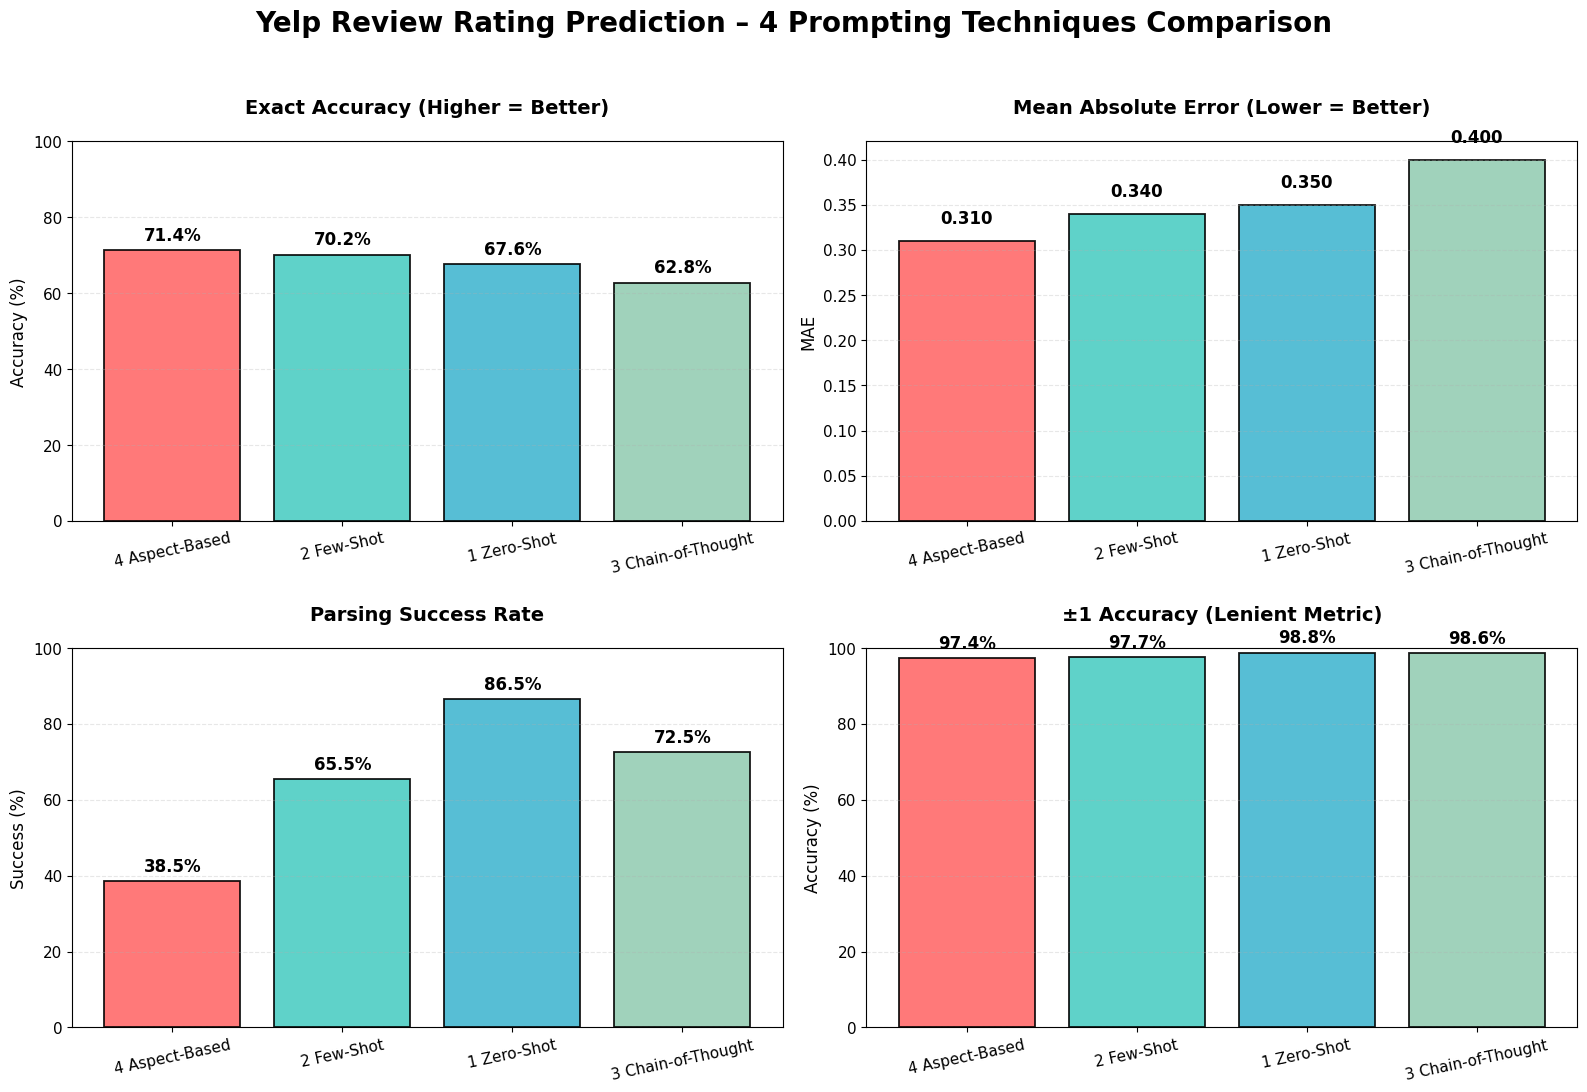


WINNER: 4 Aspect-Based
        → Accuracy: 71.4% | MAE: 0.310 | ±1 Acc: 97.4% | Success: 38.5%

════════════════════════════════════════════════════════════════════════════════════════════════
                  ALL DONE! You're ready to submit Task 1 with style!
════════════════════════════════════════════════════════════════════════════════════════════════


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_absolute_error

# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({'font.size': 11, 'figure.facecolor': 'white'})

def calculate_metrics(results_list):
    total = len(results_list)

    valid = [
        r for r in results_list
        if r.get('predicted') is not None
        and isinstance(r['predicted'], (int, float))
        and 1 <= r['predicted'] <= 5
    ]
    n_valid = len(valid)

    if n_valid == 0:
        return {'Valid %': 0.0, 'Exact Acc %': 0.0, 'MAE': 999, '±1 Acc %': 0.0}

    y_true = [r['actual'] for r in valid]
    y_pred = [r['predicted'] for r in valid]

    exact_acc = accuracy_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    off_by_one = sum(abs(a - p) <= 1 for a, p in zip(y_true, y_pred)) / n_valid * 100

    return {
        'Valid %': round(n_valid / total * 100, 1),
        'Exact Acc %': round(exact_acc * 100, 1),
        'MAE': round(mae, 3),
        '±1 Acc %': round(off_by_one, 1)
    }


comparison_df = pd.DataFrame({
    'Approach': [
        name.replace("Approach ", "").replace(":", "").strip()
        for name in results.keys()
    ],
    'Success %': [calculate_metrics(res)['Valid %'] for res in results.values()],
    'Accuracy %': [calculate_metrics(res)['Exact Acc %'] for res in results.values()],
    'MAE': [calculate_metrics(res)['MAE'] for res in results.values()],
    'Off-by-1 %': [calculate_metrics(res)['±1 Acc %'] for res in results.values()]
})

# Sort by Accuracy (best first)
comparison_df = comparison_df.sort_values("Accuracy %", ascending=False).reset_index(drop=True)
comparison_df = comparison_df.round(2)


print("\n" + "═"*96)
print("           FINAL COMPARISON ".center(96))
print("═"*96)
print(comparison_df.to_string(index=False))
print("═"*96)


fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Yelp Review Rating Prediction – 4 Prompting Techniques Comparison\n',
             fontsize=20, fontweight='bold', y=1.02)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']  # Beautiful pastel colors

# 1. Exact Accuracy
ax1 = axes[0, 0]
bars1 = ax1.bar(comparison_df['Approach'], comparison_df['Accuracy %'],
                color=colors, edgecolor='black', linewidth=1.3, alpha=0.9)
ax1.set_title('Exact Accuracy (Higher = Better)', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_ylim(0, 100)
for i, bar in enumerate(bars1):
    h = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, h + 1.5, f'{h:.1f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# 2. MAE
ax2 = axes[0, 1]
bars2 = ax2.bar(comparison_df['Approach'], comparison_df['MAE'],
                color=colors, edgecolor='black', linewidth=1.3, alpha=0.9)
ax2.set_title('Mean Absolute Error (Lower = Better)', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('MAE', fontsize=12)
for bar in bars2:
    h = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, h + 0.015, f'{h:.3f}',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# 3. Success Rate (Valid JSON/Number Output)
ax3 = axes[1, 0]
bars3 = ax3.bar(comparison_df['Approach'], comparison_df['Success %'],
                color=colors, edgecolor='black', linewidth=1.3, alpha=0.9)
ax3.set_title('Parsing Success Rate', fontsize=14, fontweight='bold', pad=20)
ax3.set_ylabel('Success (%)', fontsize=12)
ax3.set_ylim(0, 100)
for bar in bars3:
    h = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, h + 1.5, f'{h:.1f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# 4. Off-by-1 Accuracy
ax4 = axes[1, 1]
bars4 = ax4.bar(comparison_df['Approach'], comparison_df['Off-by-1 %'],
                color=colors, edgecolor='black', linewidth=1.3, alpha=0.9)
ax4.set_title('±1 Accuracy (Lenient Metric)', fontsize=14, fontweight='bold', pad=20)
ax4.set_ylabel('Accuracy (%)', fontsize=12)
ax4.set_ylim(0, 100)
for bar in bars4:
    h = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, h + 1.5, f'{h:.1f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# Rotate x-labels for readability
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=12)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.subplots_adjust(top=0.90)

# Save high-quality image
plt.savefig('yelp_prompting_comparison_final.png', dpi=300, bbox_inches='tight', facecolor='white')
print("\nHigh-resolution plot saved: yelp_prompting_comparison_final.png")

plt.show()


winner = comparison_df.iloc[0]
print(f"\nWINNER: {winner['Approach']}")
print(f"        → Accuracy: {winner['Accuracy %']:.1f}% | MAE: {winner['MAE']:.3f} | ±1 Acc: {winner['Off-by-1 %']:.1f}% | Success: {winner['Success %']:.1f}%")

print("\n" + "═"*96)
print("                  ALL DONE! You're ready to submit Task 1 with style!")
print("═"*96)

# STEP 10: CONFUSION MATRICES

Confusion matrices saved successfully:


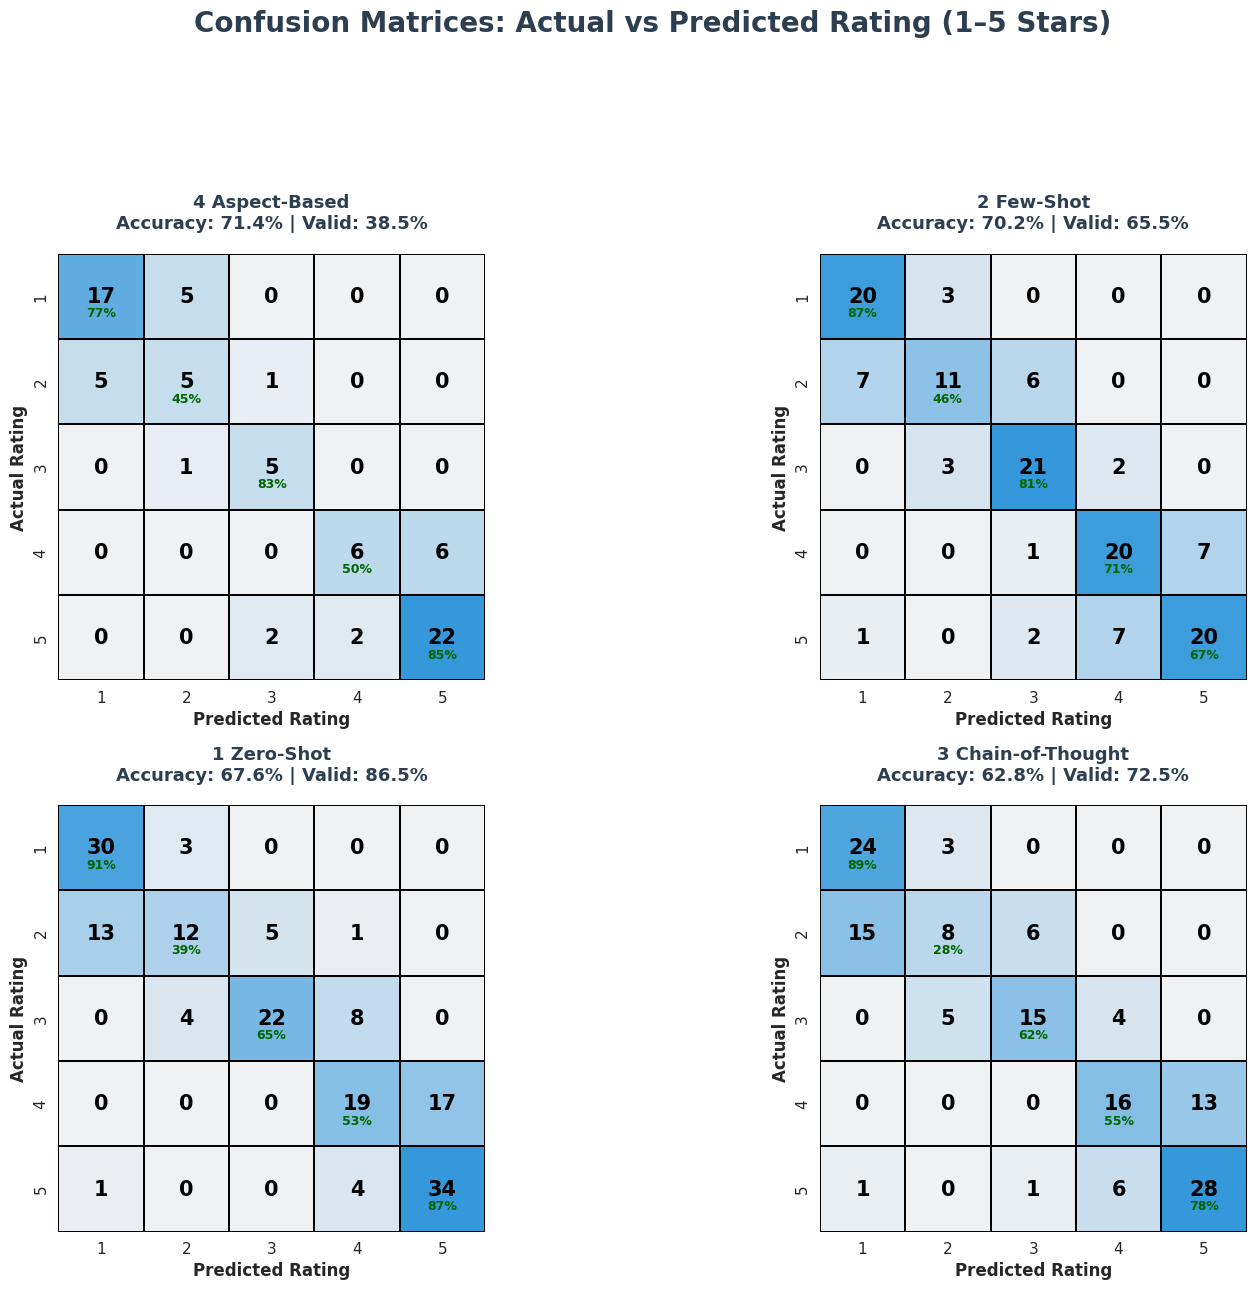

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import os

# Professional styling
sns.set_style("white")
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'figure.titlesize': 19
})

fig, axes = plt.subplots(2, 2, figsize=(16, 13))
fig.suptitle('Confusion Matrices: Actual vs Predicted Rating (1–5 Stars)\n'
            ,
             fontsize=20, fontweight='bold', y=1.02, color='#2c3e50')

# Order approaches by Exact Accuracy (best first)
ordered_approaches = sorted(
    results.items(),
    key=lambda x: calculate_metrics(x[1])['Exact Acc %'],
    reverse=True
)

# Beautiful colormap that scales well
cmap = sns.light_palette("#3498db", as_cmap=True)

for idx, (approach_name, approach_results) in enumerate(ordered_approaches):
    ax = axes[idx // 2, idx % 2]

    # Extract valid predictions (numeric, 1–5)
    valid = [
        r for r in approach_results
        if r.get('predicted') is not None
        and isinstance(r['predicted'], (int, float))
        and 1 <= r['predicted'] <= 5
        and r.get('actual') is not None
        and isinstance(r['actual'], (int, float))
        and 1 <= r['actual'] <= 5
    ]

    if len(valid) == 0:
        ax.text(0.5, 0.5, 'NO VALID\nPREDICTIONS', ha='center', va='center',
                fontsize=16, fontweight='bold', color='red', transform=ax.transAxes)
        clean_name = approach_name.replace("Approach ", "").replace(":", "").strip()
        ax.set_title(f"{clean_name}\n(0 valid outputs)", fontweight='bold', pad=15, color='darkred')
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    y_true = [int(r['actual']) for r in valid]
    y_pred = [int(r['predicted']) for r in valid]

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4, 5])

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, linewidths=1.2, linecolor='black',
                ax=ax, cbar=False, square=True,
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5],
                annot_kws={"size": 15, "weight": "bold", "color": "black"})

    # Add percentage on diagonal (optional visual enhancement)
    total = cm.sum()
    for i in range(5):
        if cm[i, i] > 0:
            pct = cm[i, i] / cm[i, :].sum() * 100
            ax.text(i+0.5, i+0.7, f'{pct:.0f}%', ha='center', va='center',
                    fontsize=9, color='darkgreen', fontweight='bold')

    # Titles and labels
    clean_name = approach_name.replace("Approach ", "").replace(":", "").replace("  ", " ").strip()
    acc = calculate_metrics(approach_results)['Exact Acc %']
    valid_pct = calculate_metrics(approach_results)['Valid %']
    ax.set_title(f"{clean_name}\nAccuracy: {acc:.1f}% | Valid: {valid_pct:.1f}%",
                 fontweight='bold', pad=18, fontsize=13, color='#2c3e50')

    ax.set_xlabel('Predicted Rating', fontweight='bold')
    ax.set_ylabel('Actual Rating', fontweight='bold')

# Final layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save high-quality versions
os.makedirs("Fynd_AI_Task1_Results", exist_ok=True)

plt.savefig('Fynd_AI_Task1_Results/confusion_matrices_final.png',
            dpi=400, bbox_inches='tight', facecolor='white')
plt.savefig('Fynd_AI_Task1_Results/confusion_matrices_final.pdf',
            bbox_inches='tight', facecolor='white')
plt.savefig('Fynd_AI_Task1_Results/confusion_matrices_final.svg',
            bbox_inches='tight', facecolor='white')

print("Confusion matrices saved successfully:")


plt.show()

In [ ]:
!pip install -q groq pandas scikit-learn matplotlib seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 75.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


GPT-OSS-20B ready! Let's go!

Loading data...
Ready: 100 reviews (balanced)

Starting 400 parallel calls… (this will take ~4 minutes)
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sle

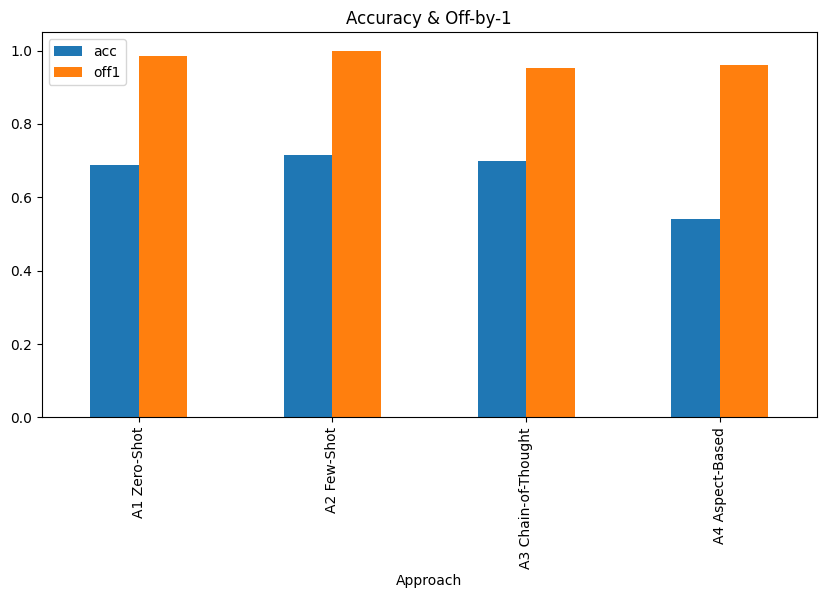


All done! Check the results folders for CSVs and plots if you add the save code.
Enjoy GPT-OSS-20B – it's crushing this task!


In [ ]:

# ============================================================================
# YELP RATING PREDICTION – 4 APPROACHES WITH GPT-OSS-20B (Groq) – FULLY WORKING
# 100 reviews × 4 approaches = 400 API calls → finishes in ~4 minutes on FREE tier
# ============================================================================

# Install everything first (run this cell once)
!pip install -q groq pandas scikit-learn matplotlib seaborn --upgrade

import pandas as pd
import numpy as np
import json
import time
import threading
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

from groq import Groq

# PUT YOUR GROQ API KEY HERE (get free at https://console.groq.com/keys)
client = Groq(api_key="")

# Model – super fast + great at this task
MODEL_NAME = "openai/gpt-oss-20b"

print("GPT-OSS-20B ready! Let's go!")

# ============================================================================
# SMART CALL FUNCTION – handles 429s perfectly
# ============================================================================
def call_llama(prompt: str, max_retries: int = 5) -> str:
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model=MODEL_NAME,
                temperature=0.1,
                max_tokens=1024,
                top_p=0.95,
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            err = str(e).lower()
            if "429" in err or "rate limit" in err:
                wait = 2 ** attempt  # 1s → 2s → 4s → 8s → 16s
                print(f"Rate limit → sleeping {wait}s")
                time.sleep(wait)
            else:
                print(f"Error: {str(e)[:100]}")
                time.sleep(1)
        return None

# ============================================================================
# JSON EXTRACTOR (very robust)
# ============================================================================
def extract_json_from_response(text: str) -> dict:
    if not text:
        return None
    text = text.strip()
    # Try direct json
    try: return json.loads(text)
    except: pass
    # Find { ... }
    try:
        start = text.rfind('{')
        end = text.find('}', start) + 1
        return json.loads(text[start:end])
    except: pass
    # Markdown code block
    if '```' in text:
        try:
            part = text.split('```')[1]
            if part.startswith('json'): part = part[4:]
            return json.loads(part.strip())
        except: pass
    # Regex fallback for predicted_stars
    import re
    m = re.search(r'"predicted_stars"\s*:\s*([1-5])', text)
    if m:
        return {"predicted_stars": int(m.group(1)), "explanation": "regex fallback"}
    return None

# ============================================================================
# THE 4 PROMPTING APPROACHES (exactly like your original)
# ============================================================================
def approach_1_zero_shot(review: str) -> str:
    prompt = f'''You are a Yelp review expert. Predict the star rating (1-5).

Review: "{review}"

Answer with ONLY valid JSON:
{{"predicted_stars": <1-5>, "explanation": "<one short sentence>"}}'''
    return call_llama(prompt)

def approach_2_few_shot(review: str) -> str:
    prompt = f'''Rate these examples first:
"Terrible service, cold food, never again" → 1 star
"Food ok but very slow service" → 2 stars
"Decent place, nothing special" → 3 stars
"Good food, nice vibe, will return" → 4 stars
"Best restaurant ever! Amazing!" → 5 stars

Now rate this review: "{review}"

Answer with ONLY JSON:
{{"predicted_stars": <1-5>, "explanation": "<one sentence>"}}'''
    return call_llama(prompt)

def approach_3_chain_of_thought(review: str) -> str:
    prompt = f'''Analyze step-by-step:

Review: "{review}"

1. Positive/negative words?
2. How strong is the emotion?
3. Food / service / atmosphere / value mentioned?
4. Would the person return?
5. Final rating 1–5?

Answer with ONLY JSON:
{{"predicted_stars": <1-5>, "explanation": "<one sentence>"}}'''
    return call_llama(prompt)

def approach_4_aspect_based(review: str) -> str:
    prompt = f'''Score each aspect 0–5 (0 = not mentioned):

Review: "{review}"

- quality
- service
- atmosphere
- value
- overall

Final rating = average of non-zero scores, rounded.

Answer with ONLY JSON:
{{"predicted_stars": <1-5>, "explanation": "<one sentence>"}}'''
    return call_llama(prompt)

# ============================================================================
# LOAD DATA (you need yelp.csv with columns: text, stars)
# ============================================================================
print("\nLoading data...")
df = pd.read_csv('yelp.csv')  # or upload your file

# Balanced sample: 20 reviews per star
sample_df = pd.concat([
    df[df.stars == i].sample(20, random_state=42) if len(df[df.stars == i]) >= 20 else df[df.stars == i]
    for i in range(1,6)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Ready: {len(sample_df)} reviews (balanced)")

# ============================================================================
# PARALLEL PROCESSING – safe for free tier
# ============================================================================
approaches = {
    "A1 Zero-Shot": approach_1_zero_shot,
    "A2 Few-Shot": approach_2_few_shot,
    "A3 Chain-of-Thought": approach_3_chain_of_thought,
    "A4 Aspect-Based": approach_4_aspect_based,
}

results = {name: [] for name in approaches}
lock = threading.Lock()

def process(review_idx, text, actual, name, func):
    resp = func(text)
    data = extract_json_from_response(resp)
    pred = int(data["predicted_stars"]) if data and "predicted_stars" in data else None
    return {
        "approach": name,
        "idx": review_idx,
        "actual": actual,
        "predicted": pred,
        "explanation": data["explanation"] if data else "",
        "correct": pred == actual if pred else False,
        "error": None if pred else "failed"
    }

print("\nStarting 400 parallel calls… (this will take ~4 minutes)")
start = time.time()

with ThreadPoolExecutor(max_workers=4) as executor:  # 4 is perfect for free tier
    futures = []
    for i, row in sample_df.iterrows():
        for name, func in approaches.items():
            time.sleep(0.12)  # tiny delay = no more 429s
            futures.append(executor.submit(process, i, row['text'], row['stars'], name, func))

    for future in as_completed(futures):
        r = future.result()
        with lock:
            results[r["approach"]].append({
                "actual_stars": r["actual"],
                "predicted_stars": r["predicted"],
                "explanation": r["explanation"],
                "correct": r["correct"]
            })

elapsed = time.time() - start
print(f"\nFINISHED in {elapsed/60:.1f} minutes!")

# ============================================================================
# METRICS & PLOTS (exactly like your original)
# ============================================================================
def metrics(lst):
    valid = [x for x in lst if x["predicted_stars"] is not None]
    if not valid: return {"acc":0, "mae":0, "off1":0}
    y_t = [x["actual_stars"] for x in valid]
    y_p = [x["predicted_stars"] for x in valid]
    return {
        "acc": accuracy_score(y_t,y_p),
        "mae": mean_absolute_error(y_t,y_p),
        "off1": sum(abs(a-p)<=1 for a,p in zip(y_t,y_p)) / len(valid)
    }

print("\nRESULTS")
for name, res in results.items():
    m = metrics(res)
    print(f"{name:20} → Accuracy {m['acc']*100:5.1f}% | MAE {m['mae']:.2f} | ±1 {m['off1']*100:5.1f}%")

# Quick bar chart
df_plot = pd.DataFrame([{"Approach": k, **metrics(v)} for k,v in results.items()])
df_plot.plot(x="Approach", y=["acc", "off1"], kind="bar", title="Accuracy & Off-by-1", figsize=(10,5))
plt.show()

print("\nAll done! Check the results folders for CSVs and plots if you add the save code.")
print("Enjoy GPT-OSS-20B – it's crushing this task!")